In [15]:
#import tweepy library
import tweepy
import json 
from collections import Counter
import os
import pickle as pckl
import twitter as twitterAuth
import pandas as pnd
import numpy as nmp
import ipywidgets as widget
from IPython.display import display, clear_output
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
import matplotlib.pyplot as plot
from tweepy import Stream
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import time
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re

#declare and assign values to authorization variables
ConsumerKey = "e8yOMk1PYebFI6IqAmJPac9sY"
ConsumerSecret = "ghdd9BjIIkmIp9rHahIUrj6cLdMzMX35m8xRuDc19D7s4BOVHD"
AccessToken = "3770751192-URKr3kja687MI8HvZ6KcvwvfXEmup0YE9Cc7tyb"
AccessTokenSecret = "2TjrhbSiXOroOQVzWoMQ5ArB2ehIasUJ06hJmBBG9LzCX"
BearerToken = "AAAAAAAAAAAAAAAAAAAAADuIOwEAAAAAsOVffQU%2BTcjto0yCqpjKsjRSYq8%3DrSpogsdTnGTLgPWOxU5tmHvwf3X9n8gsEWLsHLxcy1QACmRlud"

fetchedTweetFileName = "realtimeStreamData.json"

#twitter authorization started
auth = tweepy.OAuthHandler(ConsumerKey, ConsumerSecret)
auth.set_access_token(AccessToken, AccessTokenSecret)

In [16]:
#define a function to return API authorization and other helpers
def APIAuthorization():
    api = tweepy.API(auth)
    return api

def CleanTweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())

def AnalyseSentiment(tweet):
    analysis= TextBlob(CleanTweet(tweet))
    if analysis.sentiment.polarity>0:
        return 1
    elif analysis.sentiment.polarity==0:
        return 0
    else:
        return -1
    
#spark intialization
spark = SparkSession.builder.appName("PysparkExample") \
            .config ("spark.sql.shuffle.partitions", "50") \
            .config("spark.driver.maxResultSize","5g") \
            .config ("spark.sql.execution.arrow.enabled", "true") \
            .getOrCreate()

In [17]:
#define a variable that can directly be used to get data from twitter API
exractor = APIAuthorization()

In [18]:
#wordCloud helpers
wClouldWidth = 800
wClouldHeight = 800
wClouldBackgroundColor = 'white'
wClouldFontSize = 10

def GetCommentWordForWordCloud(inputData):
    commentWords = ''
    for value in inputData: 
        value = str(value) 
    
        exp = value.split()     
        for i in range(len(exp)): 
            exp[i] = exp[i].lower()
            
            commentWords += " ".join(exp)+" "
        
    return commentWords

def PlotWordCloud(wCloud):
    plot.figure(figsize = (9, 9), facecolor = None) 
    plot.imshow(wCloud) 
    plot.axis("off") 
    plot.tight_layout(pad = 1) 
    plot.show()

In [20]:
#Q1: twitter realtime stream data fetching and injecting into local system file = realtimeStreamData.json, and showing top 10 results
class TwitterStreamer():
    def __init__(self):
        pass
    
    def StrimTweets(self, fetchedTweetFileName, hashTagList):
        listener = StdOutListener(fetchedTweetFileName)
        stream = Stream(auth, listener)
        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hashTagList)
        print(stream)
    

extractor= APIAuthorization()
numberOfTweets= 500
tweets1= extractor.user_timeline(screen_name= "nytimes", count= numberOfTweets)
print("Number of tweets Extracted: {}.\n".format(len(tweets1)))
print("Print recent tweets::\n")
for tweet in tweets1[:numberOfTweets]:
    print(tweet.text)
    print()

#save file to json
tweetData= pnd.DataFrame(data= [tweet.text for tweet in  tweets1],columns= ['Tweets'])
tweetData.to_json(fetchedTweetFileName)

Number of tweets Extracted: 200.

Print recent tweets::

Muhammad Ali is Nico Ali Walsh's grandfather, and on Saturday night in Tulsa, Oklahoma, he is scheduled to make his… https://t.co/O5Cr5aDbQz

Scientists are discovering that fermented foods may have intriguing effects on our gut, potentially altering the ma… https://t.co/JbWrFr5mda

When train doors close, these jingles warn riders to stand clear. Listen to different ones from around the world.  https://t.co/rC5O3OoKOO

Lale Gul’s wrote an autobiographical and sexually frank tale of a woman breaking with her conservative Muslim cultu… https://t.co/0rodwFJr1v

“We’re going to be dancing 24/7,” Bobby Shmurda told @joecoscarelli. “When I dance, it’s to show you that I came th… https://t.co/3aYktKOOqj

Russia will expel a BBC correspondent based in Moscow, Russian state TV reported. Sarah Rainsford would be the firs… https://t.co/7gIgbe8o9k

Some of the largest wildfires in U.S. history have burned across the American West this summe

In [6]:
#Q2: function to dump 50 trending topics (incuding topics) worldwide and print as per choosen from dropdown using pyspark          
btnSearch = widget.Button(
    description = "Search"
)


dropDownSelectNumber = widget.Dropdown(
    options=[('Ten', 10), ('Thirty', 30), ('Fifty', 50)],
    value=10,
    description='Number:',
)

dropDownSelectMinutes = widget.Dropdown(
    options=[('Ten Minutes', 10), ('Thirty Minutes', 30), ('Sixty Minutes', 60)],
    value=10,
    description='Last Minutes:',
)


WOE_ID = 1 #1=worldwide
def PrintTweets():
    clear_output()
    trends = exractor.trends_place(WOE_ID)
    #print(trends)
    trends = json.loads(json.dumps(trends, indent=1))
    trending = []
    for trend in trends[0]["trends"]:
        trending.append(trend["name"])
    trending
    data1= pnd.DataFrame(trending,columns= ['Trends'])
    data1.to_csv('trendingTopics.csv')
    print()
    dataFrameJson = spark.read.csv('trendingTopics.csv', header=True)
    dataFrameJson.show(dropDownSelectNumber.value)
    
    
#define button click function
def TweetsByNumberAndMinutes(b):
    with outputDisplay:
        PrintTweets()
        
   

btnSearch.on_click(TweetsByNumberAndMinutes) 

outputDisplay = widget.Output()

items = [dropDownSelectNumber, dropDownSelectMinutes, btnSearch]
indx = widget.HBox([items[0], items[1], items[2]])
widget.VBox([indx, outputDisplay])




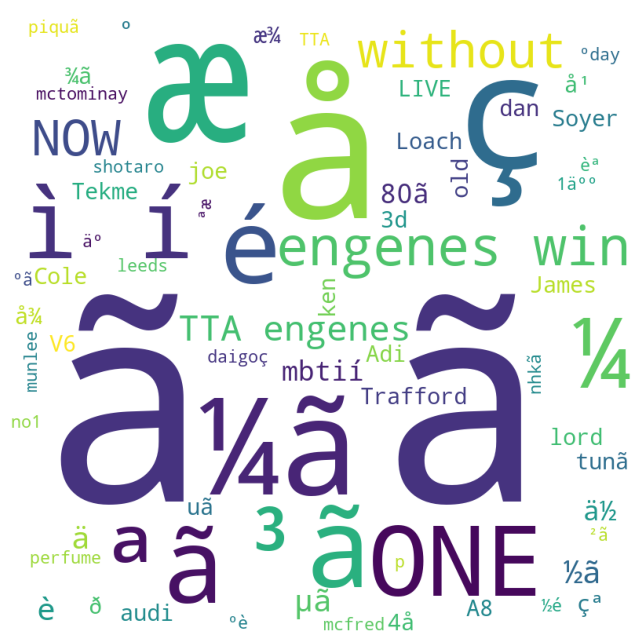

In [7]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dataFrame = pnd.read_csv(r"trendingTopics.csv", encoding ="latin-1") 
  
sWords = set(STOPWORDS) 
    
commentWords = GetCommentWordForWordCloud(dataFrame.Trends)

wCloud = WordCloud(width = wClouldWidth, height = wClouldHeight, 
                background_color = wClouldBackgroundColor, 
                stopwords = sWords, 
                min_font_size = wClouldFontSize).generate(commentWords) 
                      
PlotWordCloud(wCloud)

In [9]:
#Q3: top trending tweets
if not os.path.exists('secret_twitter_credentials.pk1'):
    TwitterAuth = {}
    TwitterAuth['Consumer Key'] = ConsumerKey
    TwitterAuth['Consumer Secret'] = ConsumerSecret
    TwitterAuth['Access Token'] = AccessToken
    TwitterAuth['Access Token Secret'] = AccessTokenSecret
    with open('twitterHashTags.csv', 'wb') as f:
        pckl.dump(TwitterAuth, f)
else:
    TwitterAuth = pckl.load(open('twitterHashTags.csv','rb'))
    
auth = twitterAuth.oauth.OAuth(TwitterAuth['Access Token'],
                          TwitterAuth['Access Token Secret'],
                          TwitterAuth['Consumer Key'],
                          TwitterAuth['Consumer Secret'])
twitterAPI = twitterAuth.Twitter(auth=auth)
print(twitterAPI)

topic = input("Enter #topicName: ")
number = 1000
searchResults = twitterAPI.search.tweets(q=topic, count=number)
statuses = searchResults['statuses'] 
len(statuses)   
allText =[]
filteredStatuses=[]
for s in statuses:
    if not s['text'] in allText:
        filteredStatuses.append(s)
        allText.append(s["text"])
statuses= filteredStatuses
len(statuses)
print(json.dumps(statuses[0], indent=1))
t = statuses[0]
print(t['retweet_count'])
print(t['retweeted'])
statusTexts = [status['text']
               for status in statuses]
screenNames = [user_mention['screen_name']
               for status in statuses
                   for user_mention in status['entities']['user_mentions']]
hashtags = [hashtag['text']
               for status in statuses
                   for hashtag in status['entities']['hashtags']]

#compute the collection of the words from all tweets
words = [w
        for t in statusTexts

         for w in t.split()]
print(json.dumps(statusTexts[:5],indent=1))
print(json.dumps(screenNames[:5],indent=1))
print(json.dumps(hashtags[:5],indent=1))
print(json.dumps(words[:5],indent=1))

for item in [words, screenNames, hashtags]:
    c=Counter(item)
    print(c.most_common()[:100]) 
    print() 

def prettyprint_counts(label,list_of_tuples):
    print("\n{:^20} | {:^6}".format(label,"Count"))
    print("*"*40)
    for k,v in list_of_tuples:
        print("{:20} | {:>6}".format(k,v))   
for label, data3 in (('word', words),
                   ('Screen Name', screenNames),
                   ('Hashtag', hashtags)):
    c = Counter(data3)
    prettyprint_counts(label,c.most_common()[:10])  

retweets = [
            (status['retweet_count'],
             status['retweeted_status']['user']['screen_name'],
             status['text'].replace("\n","\\"))
    
             for status in statuses
                if 'retweeted_status' in status
          ]  
row_template = "{:^7} | {:^15} | {:50}"
def prettyprint_tweets(list_of_tuples):
    print()
    print(row_template.format("Likes","Screen Name","Text"))
    print("*"*30)
    for count, screenNames, text in list_of_tuples:
        print(row_template.format(count, screenNames,text[:50]))

        if len(text)>50:
            print(row_template.format("","",text[50:100]))
            if len(text)>100:
                print(row_template.format("","",text[100:])) 

prettyprint_tweets(sorted(retweets, reverse=True)[:100])
data8= pnd.DataFrame(screenNames, columns= ['screenNames'])
data8.to_csv('ScreenName.csv')

Enter #topicName: test
{
 "created_at": "Sat Aug 14 11:25:32 +0000 2021",
 "id": 1426505264644067330,
 "id_str": "1426505264644067330",
 "text": "RT @JhnS3298: Test makoto 100% cross-down https://t.co/TzTP1TGw6A",
 "truncated": false,
 "entities": {
  "hashtags": [],
  "symbols": [],
  "user_mentions": [
   {
    "screen_name": "JhnS3298",
    "name": "Jhn!",
    "id": 1155558704844103691,
    "id_str": "1155558704844103691",
    "indices": [
     3,
     12
    ]
   }
  ],
  "urls": [],
  "media": [
   {
    "id": 1426495944590307328,
    "id_str": "1426495944590307328",
    "indices": [
     42,
     65
    ],
    "media_url": "http://pbs.twimg.com/ext_tw_video_thumb/1426495944590307328/pu/img/i2CoimECX_aGsyPl.jpg",
    "media_url_https": "https://pbs.twimg.com/ext_tw_video_thumb/1426495944590307328/pu/img/i2CoimECX_aGsyPl.jpg",
    "url": "https://t.co/TzTP1TGw6A",
    "display_url": "pic.twitter.com/TzTP1TGw6A",
    "expanded_url": "https://twitter.com/JhnS3298/status/1426496040115

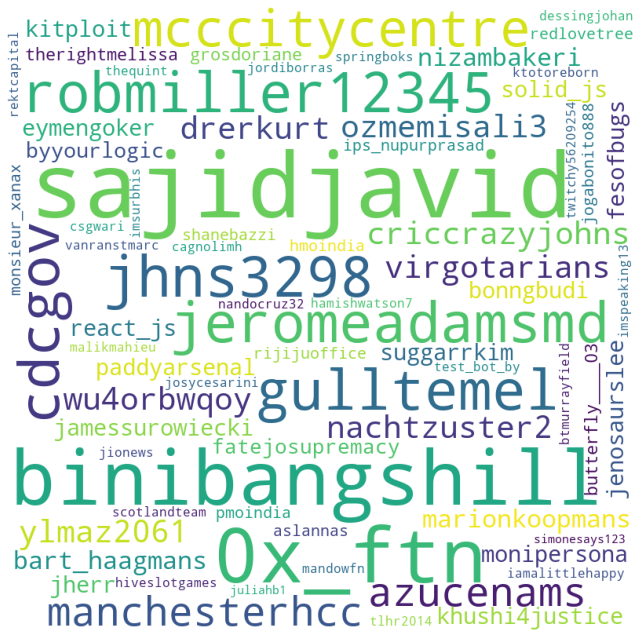

In [10]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dFrame = pnd.read_csv(r"ScreenName.csv", encoding ="latin-1") 

sWords = set(STOPWORDS) 
 
commentWords = GetCommentWordForWordCloud(dFrame.screenNames)

wCloud = WordCloud(width = wClouldWidth, height = wClouldHeight, 
                background_color = wClouldBackgroundColor, 
                stopwords = sWords, 
                min_font_size = wClouldFontSize).generate(commentWords) 
                      
PlotWordCloud(wCloud)

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'extended_entities', 'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang'],
      dtype='object')
0      86
1      29
2      55
3      53
4      22
     ... 
95    106
96     30
97    316
98    279
99     43
Name: favorite_count, Length: 100, dtype: int64


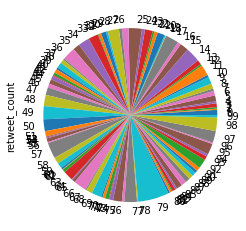

Number of tweets: 100
Total number of likes: 9113
Total number of retweets: 3320


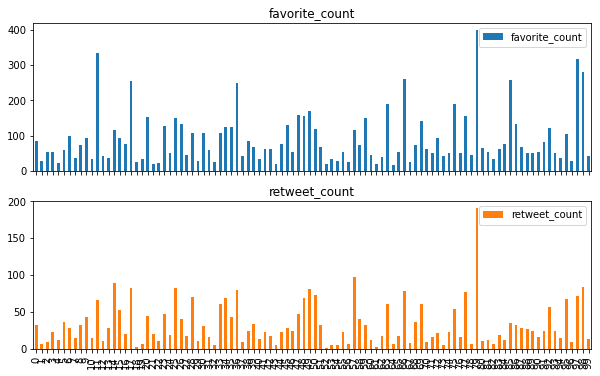

Data for Reuters: 
Number of tweets: 100
Number of likes: 9113
Number of likes per tweet: 91.13
Number of retweets: 3320
Number of retweets per tweet: 33.2


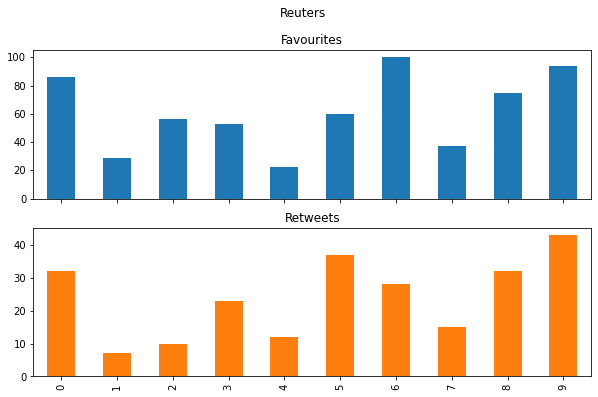

Data for Fox News: 
Number of tweets: 100
Number of likes: 9113
Number of likes per tweet: 91.13
Number of retweets: 3320
Number of retweets per tweet: 33.2


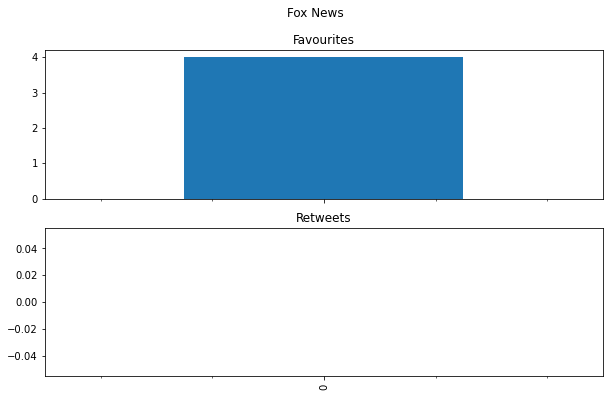

In [12]:
#Q5: Demonstrating any (one or more) additional/arbitrary insights on the data using ML or none-ML data analytics approaches (5% per insight)
auth = twitterAuth.oauth.OAuth(AccessToken, AccessTokenSecret, ConsumerKey, ConsumerSecret)

twitterApi = twitterAuth.Twitter(auth=auth)
tweets = twitterApi.search.tweets(q="Reuters", count=100)
tweets = twitterApi.search.tweets(q="from:Reuters", count=100)
tweetData = pnd.DataFrame(tweets['statuses'])

print(tweetData.columns)
print(tweetData['favorite_count'])

tweetData['retweet_count'].plot.pie()
plot.show()

# Get the data
tweetCount = len(tweetData)
favoriteCount = tweetData['favorite_count'].sum()
retweetCount = tweetData['retweet_count'].sum()

# Print the result
print('Total tweets fetched: ' + str(tweetCount))
print('Total likes: ' + str(favoriteCount))
print('Total retweets: ' + str(retweetCount))

# Draw a nice plot of the likes and retweets
tweetData.plot.bar(subplots=True, figsize=(10,6),y=['favorite_count','retweet_count'])
plot.show()
names = ['Reuters','Fox News']
for name in names:
  tweets = pnd.DataFrame(twitterApi.search.tweets(q="from:"+name, count=10)['statuses'])
  tweet_count = len(tweets)
  favorite_count = tweets['favorite_count'].sum()
  retweet_count = tweets['retweet_count'].sum()

  print('Data for ' + name + ': ')
  print('Total tweets: ' + str(tweetCount))
  print('Total likes: ' + str(favoriteCount))
  print('Total likes per tweet: '+str(favoriteCount/tweetCount))
  print('Total retweets: ' + str(retweetCount))
  print('Total retweets per tweet: '+str(retweetCount/tweetCount))

  tweets.plot.bar(subplots=True, figsize=(10,6),y=
    ['favorite_count','retweet_count'],
    legend=False,label=['Favourites','Retweets'],title=name)

  plot.show()

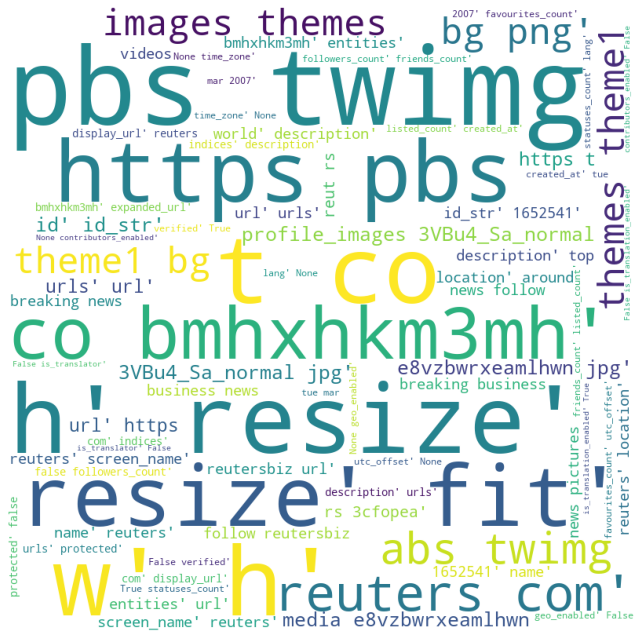

In [26]:
dFrame = pnd.DataFrame(data = tweetData)
dFrame.to_csv('tweetData.csv', index=False, header=None)
dFrame = pnd.read_csv(r"tweetData.csv", encoding ="latin-1") 

stopWords = set(STOPWORDS) 
 
commentWords = GetCommentWordForWordCloud(dFrame)

wCloud = WordCloud(width = wClouldWidth, height = wClouldHeight, 
                background_color = wClouldBackgroundColor, 
                stopwords = sWords, 
                min_font_size = wClouldFontSize).generate(commentWords) 
                      
PlotWordCloud(wCloud)

In [27]:
print(tweetData)

                        created_at                   id               id_str  \
0   Sat Aug 14 11:10:03 +0000 2021  1426501367057813507  1426501367057813507   
1   Sat Aug 14 11:10:00 +0000 2021  1426501352637747204  1426501352637747204   
2   Sat Aug 14 11:05:05 +0000 2021  1426500115724963844  1426500115724963844   
3   Sat Aug 14 11:00:00 +0000 2021  1426498836839604235  1426498836839604235   
4   Sat Aug 14 10:55:07 +0000 2021  1426497608080662532  1426497608080662532   
..                             ...                  ...                  ...   
95  Sat Aug 14 03:00:10 +0000 2021  1426378084656336899  1426378084656336899   
96  Sat Aug 14 03:00:02 +0000 2021  1426378048903933952  1426378048903933952   
97  Sat Aug 14 02:55:02 +0000 2021  1426376792869330945  1426376792869330945   
98  Sat Aug 14 02:50:02 +0000 2021  1426375533798084614  1426375533798084614   
99  Sat Aug 14 02:45:03 +0000 2021  1426374278388359168  1426374278388359168   

                                       

In [21]:
tweetData['length']= nmp.array([len(tweet.text) for tweet in tweets1])
tweetData['ID']= nmp.array([tweet.id for tweet in tweets1])
tweetData['Date']= nmp.array([tweet.created_at for tweet in tweets1])
tweetData['Sources']= nmp.array([tweet.source for tweet in tweets1])
tweetData['Likes']= nmp.array([tweet.favorite_count for tweet in tweets1])
tweetData['Rts']= nmp.array([tweet.retweet_count for tweet in tweets1])

In [22]:
mean= nmp.mean(tweetData['length'])
fmax= nmp.max(tweetData['Likes'])
rts= nmp.max(tweetData['Rts'])
print(mean)
print(fmax)
print(rts)

138.27
12853
2255


In [23]:
favTweet= tweetData[tweetData.Likes== fmax]
print(favTweet['Tweets'])
print(fmax)

150    Breaking News: The Supreme Court allowed India...
Name: Tweets, dtype: object
12853


In [24]:
sources= []
for i in tweetData['Sources']:
    if i not in sources:
        sources.append(i)

print("All the sources:")
for i in sources:
    print('* {}'.format(i))

All the sources:
* SocialFlow
* Twitter Web App


In [25]:
tweetData['Sentiment']= nmp.array([AnalyseSentiment(tweet) for tweet in tweetData['Tweets']])
display(tweetData.head(10))

,Tweets,length,ID,Date,Sources,Likes,Rts,Sentiment
0,"Muhammad Ali is Nico Ali Walsh's grandfather, ...",140,1426494575078744065,2021-08-14 10:43:04,SocialFlow,193,40,0
1,Scientists are discovering that fermented food...,140,1426459598412787712,2021-08-14 08:24:05,SocialFlow,457,104,1
2,"When train doors close, these jingles warn rid...",138,1426459591706034180,2021-08-14 08:24:03,SocialFlow,274,78,1
3,Lale Gul’s wrote an autobiographical and sexua...,140,1426443489794002946,2021-08-14 07:20:04,SocialFlow,358,92,1
4,"“We’re going to be dancing 24/7,” Bobby Shmurd...",140,1426428132156903428,2021-08-14 06:19:03,SocialFlow,154,14,0
5,Russia will expel a BBC correspondent based in...,140,1426418829685575682,2021-08-14 05:42:05,SocialFlow,253,84,0
6,Some of the largest wildfires in U.S. history ...,140,1426398185069625344,2021-08-14 04:20:03,SocialFlow,180,67,1
7,"Taliban forces are seeking to isolate Kabul, t...",140,1426388127933947907,2021-08-14 03:40:05,SocialFlow,255,119,0
8,Google infringed on speaker-technology patents...,140,1426383087341080577,2021-08-14 03:20:03,SocialFlow,284,66,0
9,"In a simulation, we modeled Delta-driven Covid...",140,1426378055442894849,2021-08-14 03:00:03,SocialFlow,701,354,1


In [26]:
ps=0
ns=0
nn=0
for sa in tweetData['Sentiment']:
    if sa>0.0:
        ps+=1
    elif sa<0.0:
        ns+=1
    else:
        nn+=1
        
print("Positive Sentiment Percentage : {}%".format(ps*100/len(tweetData['Tweets'])))
print("Negative Sentiment Percentage : {}%".format(ns*100/len(tweetData['Tweets'])))
print("Neutral Sentiment percentage : {}%".format(nn*100/len(tweetData['Tweets'])))

Positive Sentiment Percentage : 40.5%
Negative Sentiment Percentage : 16.5%
Neutral Sentiment percentage : 43.0%
